In [1]:
!pip install tokenizers
import tensorflow as tf
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, Regex
import tokenizers
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.9 MB/s eta 0:00:0000:0100:01


2023-05-07 20:20:31.433480: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'bilstm'

In [3]:
!ls /home/

user


# Load data

In [4]:
df = pd.read_csv('/home/user/files_for_research_Vova/processed_data.csv', usecols=['review_translate',
                                                            'dataset_name',
                                                            'rating',
                                                           'translated'])

In [5]:
df.head()

,review_translate,rating,dataset_name,translated
0,"Якісна пластмаса , переворот 360 градусвв",5.0,rozetka,False
1,За такі гроші це самий топ,5.0,rozetka,False
2,За такі гроші - просто супер ! Рекомендую .,5.0,rozetka,False
3,Виконує свою роботу не погано . але що ви хоті...,4.0,rozetka,False
4,Купляв на стару сістему як основний під віндов...,4.0,rozetka,False


In [6]:
subsets = pd.read_csv('/home/user/files_for_research_Vova/train_val_test_indices.csv')

In [7]:
subsets.head()

,index,split
0,0,train
1,1,test
2,2,train
3,3,train
4,4,train


In [8]:
subsets = subsets.merge(df[['dataset_name', 'translated']], left_on='index', right_index=True)

In [9]:
bad_indices = pd.read_csv('/home/user/files_for_research_Vova/files_to_check.csv')
subsets = subsets[~subsets.index.isin(bad_indices['id'].values)]
df = df[~df.index.isin(bad_indices['id'].values)]
df, subsets = df.reset_index().drop(columns='index'), subsets.reset_index().drop(columns='index')

# Load tokenizer

In [10]:
tokenizer = Tokenizer.from_file("/home/user/files_for_research_Vova/tokenizer_30k.json")


# Encode text

In [11]:
import seaborn as sns
import numpy as np

In [12]:
sns.set()

In [13]:
df['review_translate'] = df['review_translate'].str.lower()

In [14]:
df['encoded'] = tokenizer.encode_batch(df['review_translate'].values)

In [15]:
df['encoded'] = df['encoded'].apply(lambda x: x.ids)

/tmp/ipykernel_1/3749403729.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(df['encoded'].apply(len)))


<AxesSubplot: xlabel='encoded', ylabel='Density'>

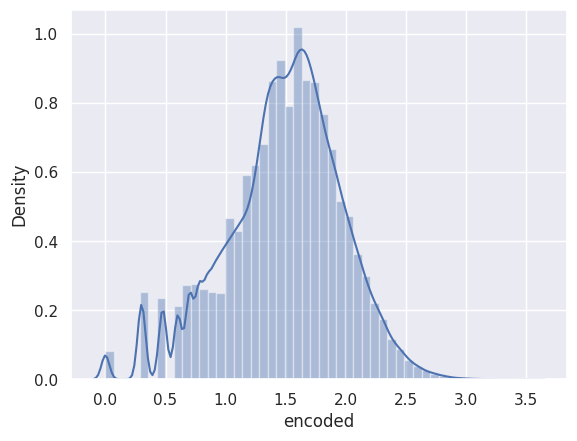

In [16]:
sns.distplot(np.log10(df['encoded'].apply(len)))

In [17]:
np.percentile(df['encoded'].apply(len), 99)

324.0

In [18]:
encoded_tokens = df['encoded'].values

In [19]:
from itertools import chain

In [20]:
padded_tokens = tf.keras.preprocessing.sequence\
.pad_sequences(encoded_tokens, maxlen=300, padding="post")


In [21]:
padded_tokens.shape

(655470, 300)

# Get labels and split data

In [22]:
mapping = dict([(i,c) for c,i in enumerate(df['rating'].unique())])

In [23]:
y = df['rating'].map(mapping).values

In [24]:
num_classes = len(set(y))

In [25]:
train_indices, val_indices, test_indices = subsets[subsets['split']=='train'].index.tolist(),\
subsets[subsets['split']=='val'].index.tolist(),\
subsets[subsets['split']=='test'].index.tolist()


In [26]:
train_y, val_y, test_y = y[train_indices], y[val_indices], y[test_indices]

In [27]:
train_x, val_x, test_x = padded_tokens[train_indices], padded_tokens[val_indices],\
padded_tokens[test_indices]

In [28]:
train_x.shape

(524346, 300)

# Create  model

In [29]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
input_layer = tf.keras.layers.Input(shape=(300,), name='input')
word_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.get_vocab_size(),
                                                   output_dim=300,
                                                   trainable=True,
                                           name='embedding',
                                           mask_zero=True
                                                   )
dropout = tf.keras.layers.SpatialDropout1D(0.3)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, name='lstm'))
embedded = dropout(word_embedding(input_layer))
hidden = lstm(embedded)
x = tf.keras.layers.Dense(128, activation='relu', name='dense')(hidden)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(x)
model = tf.keras.Model(input_layer, output)

2023-05-07 20:21:30.689450: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 20:21:30.852065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14148 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:03:00.0, compute capability: 8.6


# Compile model

In [30]:
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

# Early stopping

In [31]:
import operator
class EarlyStopping:
    def __init__(self, tolerance=5, mode='min'):
        assert mode in ['min','max'], 'Mode should be min or max'
        self.mode = operator.lt if mode=='min' else operator.gt 
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.extremum_value = None
        self.best_model = None
    
    @staticmethod
    def copy_model(model):
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())
        return copied_model
        
    def __call__(self, val, model):
        if self.extremum_value is None:
            self.extremum_value = val
            self.best_model = self.copy_model(model)
        else:
            if not self.mode(val, self.extremum_value):
                self.counter+=1
            else:
                self.extremum_value = val
                self.best_model = self.copy_model(model)
                self.counter = 0
        
        if self.counter==self.tolerance:
            self.early_stop=True

# Train model

In [32]:
from sklearn.metrics import f1_score

In [35]:
def evaluate_on_datasets(y_true, y_pred, split='val'):
    d = {}
    for dataset_name in subsets['dataset_name'].unique():
            idx = subsets[subsets['split']==split].copy()
            idx['index'] = list(range(idx.shape[0]))
            idx = idx[(idx['dataset_name']==dataset_name)]\
            ['index'].values.tolist()
            score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
            print(f'{split} f1 score for dataset {dataset_name} : {score}')
            d[f'{split}_f1_{dataset_name}'] = score
            
    for flag in [True, False]:
        idx = subsets[subsets['split']==split].copy()
        idx['index'] = list(range(idx.shape[0]))
        idx = idx[idx['translated']==flag]['index'].values.tolist()
        score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
        print(f'{split} f1 score for translated=={flag} : {score}')
        d[f'{split}_f1_translated=={flag}'] = score
    return d

In [36]:
def update_history(history, d):
    for key, value in d.items():
        res = history.get(key, [])
        res.append(value)
        history[key] = res

In [37]:
early_stopping = EarlyStopping(mode='max', tolerance=4)

In [39]:
def training_loop(model, epochs=10, batch_size=128):
    dict_history = {}
    for i in range(epochs):
        
        #train model
        history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
          epochs=1, batch_size=batch_size,
                           verbose=0)
        train_loss, val_loss = history.history['loss'][-1], history.history['val_loss'][-1]
        
        #evaluate model
        train_prediction = np.argmax(model.predict(train_x, batch_size=batch_size), axis=-1)
        val_prediction = np.argmax(model.predict(val_x, batch_size=batch_size), axis=-1)
        train_f1 = f1_score(y_true=train_y, y_pred=train_prediction,
                           average='macro')
        val_f1 = f1_score(y_true=val_y, y_pred=val_prediction,
                         average='macro')
        
        #printing evaluation
        print(f'Epoch {i}')
        print(f'Overall train f1 : {train_f1}, overall val f1: {val_f1}')
        print(f'Train loss : {train_loss}, val loss: {val_loss}')
        d_train = evaluate_on_datasets(y_true=train_y, y_pred=train_prediction, split='train')
        d_val = evaluate_on_datasets(y_true=val_y, y_pred=val_prediction, split='val')
            
        if i!=epochs-1:
            print('-'*30)
            
        #save history
        update_history(dict_history, d_train)
        update_history(dict_history, d_val)
        update_history(dict_history, {'train_f1': train_f1})
        update_history(dict_history, {'val_f1': val_f1})
        update_history(dict_history, {'train_loss': train_loss})
        update_history(dict_history, {'val_loss': val_loss})
        #early stopping
        
        early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print('Stopping early')
            model = early_stopping.best_model
            break
        
    return dict_history, model

In [40]:
dict_history, model = \
training_loop(model, epochs=20, batch_size=1024)

2023-05-07 20:22:01.771212: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-05-07 20:22:02.120046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-05-07 20:22:02.448148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-07 20:22:02.510750: I tensorflow/compiler/xla/servic

65/65 [==============================] - 2s 28ms/step
Epoch 0
Overall train f1 : 0.4909542710069893, overall val f1: 0.46315861074759185
Train loss : 0.7250731587409973, val loss: 0.6465298533439636
train f1 score for dataset rozetka : 0.437367747642386
train f1 score for dataset tripadvisor_hotels_ukraine : 0.5293523900508075
train f1 score for dataset tripadvisor_restaurants_ukraine : 0.5256623980390459
train f1 score for translated==True : 0.4983898927232565
train f1 score for translated==False : 0.43437107813815246
val f1 score for dataset rozetka : 0.4095496084745546
val f1 score for dataset tripadvisor_hotels_ukraine : 0.5005684022552526
val f1 score for dataset tripadvisor_restaurants_ukraine : 0.4981498844302175
val f1 score for translated==True : 0.4702923295482476
val f1 score for translated==False : 0.4073151833273066
------------------------------
65/65 [==============================] - 2s 28ms/step
Epoch 1
Overall train f1 : 0.5542993990260499, overall val f1: 0.491141153

In [41]:
dict_history

{'train_f1_rozetka': [0.437367747642386,
  0.5145919734381261,
  0.5827558257036892,
  0.6084245082248224,
  0.6738936014350353,
  0.6911650425137446,
  0.6834039786126838,
  0.7247121419701938,
  0.7482842330655494],
 'train_f1_tripadvisor_hotels_ukraine': [0.5293523900508075,
  0.5719446881362562,
  0.6330626778503772,
  0.6543406384852164,
  0.7198837932369796,
  0.734854522991452,
  0.6989184547895867,
  0.7331359867389742,
  0.7771732476960734],
 'train_f1_tripadvisor_restaurants_ukraine': [0.5256623980390459,
  0.5849139379480904,
  0.6367493313244652,
  0.656020880666486,
  0.7206720262070402,
  0.7312515978852716,
  0.7035005439187242,
  0.7424191138057445,
  0.7743206887428986],
 'train_f1_translated==True': [0.4983898927232565,
  0.5591699414255232,
  0.617663556220885,
  0.6391226032526481,
  0.7036721205349766,
  0.717215691012618,
  0.6967332489258288,
  0.7351496298311879,
  0.7659238120857308],
 'train_f1_translated==False': [0.43437107813815246,
  0.5176429874952249,
  

# Show charts

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
def plot_history(dict_history, columns):
    plt.figure(figsize=(12,8))
    for i in columns:
        to_plot = dict_history[i]
        plt.plot(range(len(to_plot)), to_plot, 'o-')
    plt.xticks(range(len(to_plot)), range(len(to_plot)))
    plt.xlabel('Epochs')
    plt.legend(columns)

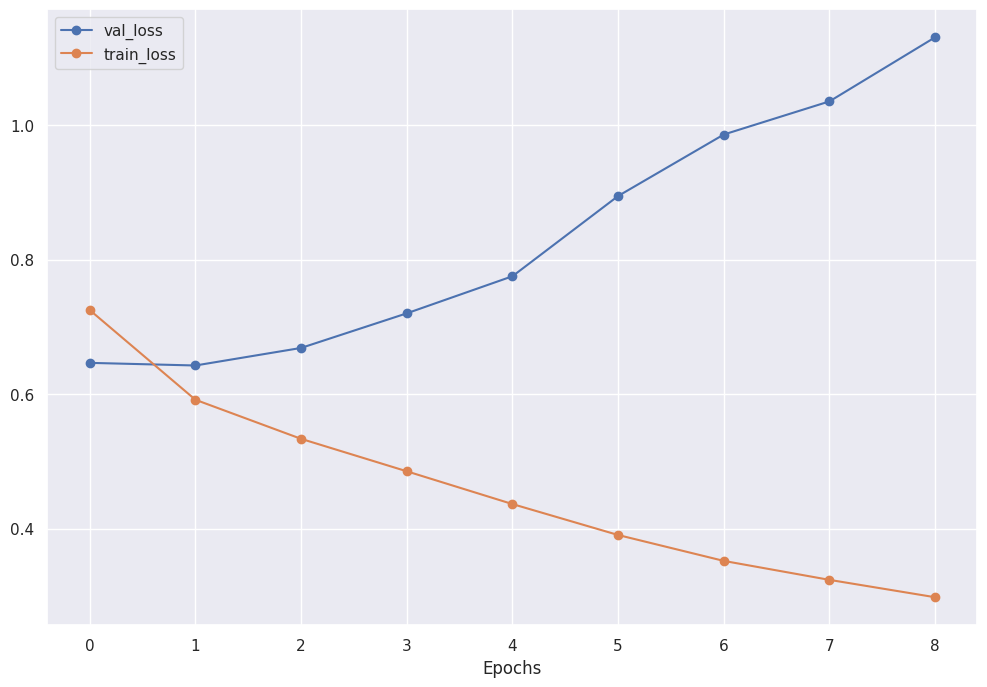

In [44]:
plot_history(dict_history, ['val_loss', 'train_loss'])

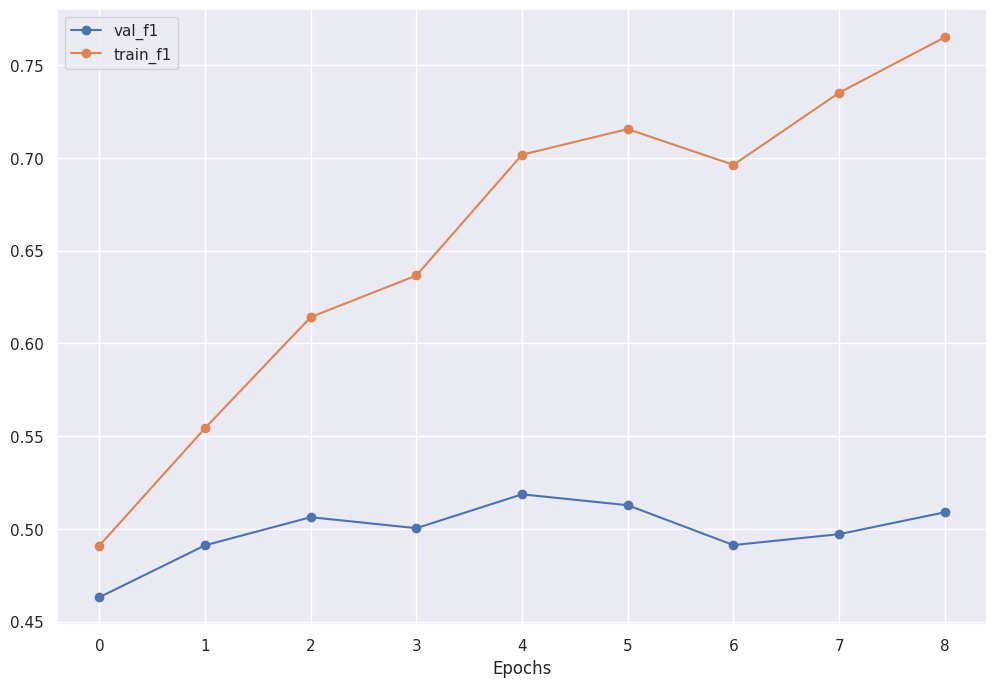

In [45]:
plot_history(dict_history, ['val_f1', 'train_f1'])

# Evaluate model

In [46]:
test_predictions = np.argmax(model.predict(test_x, batch_size=1024), axis=-1)

65/65 [==============================] - 5s 28ms/step


In [56]:
test_f1 = f1_score(y_true=test_y, y_pred=test_predictions,
                         average='macro')
print(f'Overall test f1-score : {test_f1}')

Overall test f1-score : 0.5170779404855335


In [57]:
test_results = evaluate_on_datasets(y_true=test_y, y_pred=test_predictions,split='test')
                     

test f1 score for dataset rozetka : 0.48337212491971
test f1 score for dataset tripadvisor_hotels_ukraine : 0.532364525215911
test f1 score for dataset tripadvisor_restaurants_ukraine : 0.5408745555941045
test f1 score for translated==True : 0.5217788794936691
test f1 score for translated==False : 0.48064572931906735


# Confusion matrix

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
np.unique(test_y)

array([0, 1, 2, 3, 4])

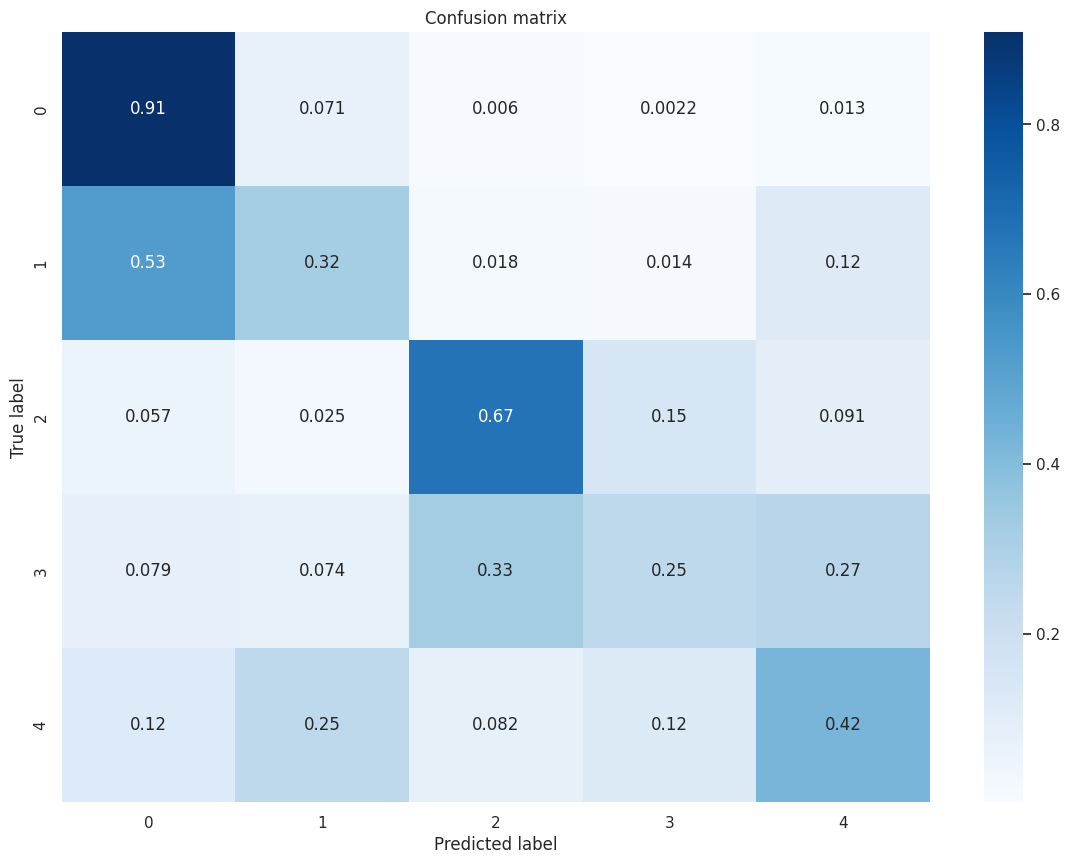

In [51]:
matrix = confusion_matrix(test_y, test_predictions)
matrix_scaled = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,10))
sns.heatmap(matrix_scaled, annot=True, cmap=plt.cm.Blues, xticklabels=np.unique(test_y),\
            yticklabels=np.unique(test_y))
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

# Save history results

In [63]:
history = pd.DataFrame(dict_history)
for k,v in test_results.items():
    history[k] = v

In [64]:
history['model'] = model_name

In [65]:
history

,train_f1_rozetka,train_f1_tripadvisor_hotels_ukraine,train_f1_tripadvisor_restaurants_ukraine,train_f1_translated==True,train_f1_translated==False,val_f1_rozetka,val_f1_tripadvisor_hotels_ukraine,val_f1_tripadvisor_restaurants_ukraine,val_f1_translated==True,val_f1_translated==False,train_f1,val_f1,train_loss,val_loss,test_f1_rozetka,test_f1_tripadvisor_hotels_ukraine,test_f1_tripadvisor_restaurants_ukraine,test_f1_translated==True,test_f1_translated==False,model
0,0.437368,0.529352,0.525662,0.498390,0.434371,0.409550,0.500568,0.498150,0.470292,0.407315,0.490954,0.463159,0.725073,0.646530,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
1,0.514592,0.571945,0.584914,0.559170,0.517643,0.449691,0.513725,0.521086,0.497585,0.441623,0.554299,0.491141,0.591681,0.642615,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
2,0.582756,0.633063,0.636749,0.617664,0.588016,0.472047,0.521285,0.533549,0.511982,0.464671,0.614116,0.506304,0.533555,0.668722,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
3,0.608425,0.654341,0.656021,0.639123,0.616958,0.467393,0.503942,0.529494,0.506032,0.459286,0.636570,0.500384,0.485310,0.720171,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
4,0.673894,0.719884,0.720672,0.703672,0.685187,0.486793,0.520633,0.546323,0.523292,0.483090,0.701669,0.518626,0.436568,0.775323,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
5,0.691165,0.734855,0.731252,0.717216,0.700861,0.484816,0.518656,0.535526,0.516901,0.480668,0.715467,0.512759,0.390567,0.894633,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
6,0.683404,0.698918,0.703501,0.696733,0.689903,0.470232,0.487286,0.510481,0.494687,0.464711,0.696176,0.491269,0.352046,0.986064,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
7,0.724712,0.733136,0.742419,0.735150,0.732250,0.480571,0.489155,0.513618,0.499497,0.478186,0.735042,0.497166,0.323857,1.035356,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm
8,0.748284,0.777173,0.774321,0.765924,0.756028,0.491680,0.499919,0.524590,0.511922,0.485433,0.764956,0.508947,0.298018,1.130679,0.483372,0.532365,0.540875,0.521779,0.480646,bilstm


In [66]:
history.to_csv("/home/user/jupyter_notebooks/Ukranian-SA/notebooks/training/training_results_filtered.csv", mode='a', header=None, index=None)

In [ ]:
model.save(f'/home/user/files_for_research_Vova/{model_name}.h5')